## Building a CNN and Training on CIFAR-10 dataset

Train a convolutional neural network on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The network architecture should be as follows:

- Input layer: Accepts 32x32x3 images
- Convolution layer: 6 filters, filter size 5x5x3, stride 1
- ReLU layer: Accepts and returns a 32x32x6 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Convolution layer: 12 filters, filter size 5x5x6, stride 1
- ReLU layer: Accepts and returns a 16x16x12 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Convolution layer: 24 filters, filter size 5x5x12, stride 1
- ReLU layer: Accepts and returns a 8x8x24 tensor
- Max pooling layer: Pooling size 2x2, stride 2
- Fully connected network with 2 hidden layers: Accepts a flattened tensor of dimension 4x4x24 and outputs a 10-dimensional tensor containing the predicted class labels. The layer dimensions should be [384,120,84,10].

Notice how in each layer the number of filters is doubled, while the feature resolution is halved (_hint: make sure you use the appropriate amount of padding to achieve this_). Use the multi-class cross entropy loss function and the Adam optimizer with a learning rate of $10^{-3}$. Train the network for a total of 20000 iterations using a batch size of 128 images. Report the loss as a function of the training iterations, and the resulting confusion matrix for the test data-set. What do you notice here? Propose changes to improve the accuracy over the test set, and verify that you see an improvement of atleast 3% with your changes.


In [1]:
import jax.numpy as np
import numpy as onp
from jax import vmap, grad, random, jit
from jax.example_libraries import stax, optimizers
from jax.example_libraries.stax import Dense, Conv, Relu, MaxPool, Flatten, Softmax
from jax.nn import one_hot

import itertools
from functools import partial
from tqdm import trange
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

In [2]:
from keras.datasets import cifar10
# loading the dataset 
(X_TRAIN, y_TRAIN), (X_TEST, y_TEST) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [6]:
X_train = X_TRAIN / 255 # Images
y_train = (y_TRAIN / 255).reshape(-1, ) # Index 0 to 9, no of classes= 10

# Labels should be a one-hot vector
num_classes = y_TRAIN.max() + 1
y_train = one_hot(y_train, num_classes) # Labels

In [7]:
def show_me(X_train, y_train, i):
  plt.figure(figsize = (15, 2))
  plt.imshow(X_train[i])
  plt.xlabel(classes[y_TRAIN[i, 0]])

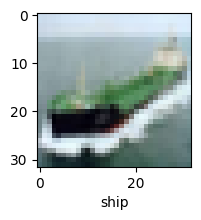

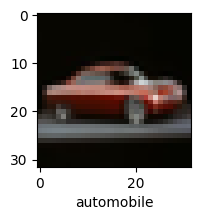

In [8]:
# Plotting to see:
show_me(X_train, y_train, 190)
show_me(X_TRAIN, y_train, 134)

In [9]:
# Some helper functions for visualization
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_filters(conv, shape, title):
    plt.figure(figsize=(5, 4))
    cnt=0
    m, n = shape
    for i in range(m):
      for j in range(n):
          cnt+=1
          plt.subplot(m,n,cnt)   
          plt.imshow(conv[0,:,:,cnt]) 
          plt.axis('off')
    fig = plt.gcf()
    fig.suptitle(title)

In [10]:
# Architecture
def CNN():
    init, apply = stax.serial(Conv(6, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              Conv(12, (5, 5), (1, 1), padding="SAME"),
                              Relu, MaxPool((2, 2), (2, 2)),
                              Conv(24, (5, 5), (1, 1), padding="SAME"),
                              Relu, Flatten,
                              Dense(384), Relu, 
                              Dense(120), Relu, 
                              Dense(84), Relu, 
                              Dense(10), Softmax)
    return init, apply

In [11]:
# Defining the keys for the model and the data loader:
# Doing this before due to some strange bug on JAX (REF:https://github.com/google/jax/issues/15084)
rng_model = random.PRNGKey(0)
rng_dataloader = random.PRNGKey(42)

In [12]:
class CNNclassifier:
    # Initialize the class
    def __init__(self):
        # MLP init and apply functions
        self.net_init, self.net_apply = CNN()
        _, params = self.net_init(rng_model, (-1, 32, 32, 3))


        # Optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    
    # Define a cross entropy loss:
    def loss(self, params, batch):
        images, labels = batch
        outputs = self.net_apply(params, images)
        loss = -labels * np.log(outputs)
        return np.mean(loss)

    @partial(jit, static_argnums=(0, ))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        gradients = grad(self.loss)(params, batch)
        return self.opt_update(i, gradients, opt_state)

    def train(self, dataset, nIter = 10):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Run one gradient descent update
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)  
            if it % 50 == 0:
                # Logger
                params = self.get_params(self.opt_state)
                loss = self.loss(params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'Loss': loss})

    @partial(jit, static_argnums=(0, ))
    def predict(self, params, inputs):
        outputs = self.net_apply(params, inputs)
        return outputs

In [13]:
import torchvision as tv
from torch.utils import data
class DataGenerator(data.Dataset):
    def __init__(self, images, labels, 
                 batch_size=128, 
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.images = images
        self.labels = labels
        self.N = labels.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key, images, labels):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        images = images[idx,...]
        labels = labels[idx,...]
        return images, labels

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        images, labels = self.__data_generation(self.key, self.images, self.labels)
        return images, labels

In [14]:
# Create data iteraror
train_dataset = DataGenerator(X_train, y_train, batch_size=128, rng_key = rng_dataloader)

In [15]:
model = CNNclassifier()

In [18]:
#  this is how you get the model parameters
params = model.get_params(model.opt_state)
data = iter(train_dataset)
batch = next(data)
images, labels = next(data)

outputs = model.net_apply(params, images)
# print(outputs)
loss = model.loss(params, batch)
# print(loss)
# print(params)
print(type(model.opt_state))
print(labels.shape)

<class 'jax.example_libraries.optimizers.OptimizerState'>
(128, 10)


In [19]:
print(type(model.opt_state))

<class 'jax.example_libraries.optimizers.OptimizerState'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Train model
model.train(train_dataset, nIter=10000)

opt_params = model.get_params(model.opt_state)
# Plot loss
plt.figure()
plt.plot(model.loss_log, lw=2)
plt.yscale('log')
plt.xlabel('Iter #')
plt.ylabel('Loss')

  0%|          | 0/10000 [00:00<?, ?it/s]